In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
import pickle
# import re
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm, linear_model
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import imp 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [2]:
# Function for extracting channel names from filename
def chan_labels_from_fname(in_file):
    just_fname=in_file.split('/')[-1]
    jf_splt=just_fname.split('_')
    chan_label=jf_splt[1]+'-'+jf_splt[2]
    return chan_label

In [3]:
# Get size of a subject's data (and filenames)
def data_size_and_fnames(sub_list,ftr_root):
    grand_non_fnames=list()
    grand_szr_fnames=list()
    grand_n_szr_wind=0
    grand_n_non_wind=0
    for sub in sub_list:
        print('Working on sub %d' % sub)
        non_fnames=list()
        szr_fnames=list()
        
        ftr_path=os.path.join(ftr_root,str(sub))
        for f in os.listdir(ftr_path):
            if f.endswith('non.mat'):
                non_fnames.append(os.path.join(ftr_root,str(sub),f))
            elif f.endswith('.mat') and f.startswith(str(sub)+'_'):
                szr_fnames.append(os.path.join(ftr_root,str(sub),f))

        print('%d non-szr files found' % len(non_fnames))
        print('%d szr files found' % len(szr_fnames))  

        # Loop over NON-szr files to get total # of windows
        n_non_wind=0
        ftr_dim=0
        for f in non_fnames:
            temp_ftrs=sio.loadmat(f)
            ##print(temp_ftrs.keys())
            n_non_wind+=temp_ftrs['nonszr_se_ftrs'].shape[1]
            if ftr_dim==0:
                ftr_dim=temp_ftrs['nonszr_se_ftrs'].shape[0]
            elif ftr_dim!=temp_ftrs['nonszr_se_ftrs'].shape[0]:
                raise ValueError('# of features in file does match previous files')

        print('%d total # of NON-szr time windows for this sub' % n_non_wind)

        # Loop over SZR files to get total # of windows
        n_szr_wind=0
        for f in szr_fnames:
            temp_ftrs=sio.loadmat(f)
            ##print(temp_ftrs.keys())
            n_szr_wind+=temp_ftrs['se_ftrs'].shape[1]
        print('%d total # of SZR time windows for this sub' % n_szr_wind)
        
        grand_non_fnames+=non_fnames
        grand_szr_fnames+=szr_fnames
        grand_n_szr_wind+=n_szr_wind
        grand_n_non_wind+=n_non_wind
        
    return grand_szr_fnames, grand_non_fnames, grand_n_szr_wind, grand_n_non_wind, ftr_dim

In [4]:
def import_data(szr_fnames, non_fnames, n_szr_wind, n_non_wind, ftr_dim):
    #ftr_path=os.path.join(ftr_root,str(sub))
        
    # Preallocate memory
    ftrs=np.zeros((ftr_dim,n_szr_wind+n_non_wind))
    targ_labels=np.zeros(n_szr_wind+n_non_wind)
    sub_ids=np.zeros(n_szr_wind + n_non_wind)
    
    # Import non-szr data
    ptr=0
    mns_dict=dict()
    sds_dict=dict()
    for f in non_fnames:
#         print(f)
        chan_label=chan_labels_from_fname(f)

        temp_ftrs=sio.loadmat(f)
        temp_n_wind=temp_ftrs['nonszr_se_ftrs'].shape[1]
        raw_ftrs=temp_ftrs['nonszr_se_ftrs']
        # Z-score features
        temp_mns, temp_sds=dg.trimmed_normalize(raw_ftrs,0,zero_nans=False,verbose=False)
        #temp_mns, temp_sds=dg.trimmed_normalize(raw_ftrs,0.3,zero_nans=False,verbose=False)
        mns_dict[chan_label]=temp_mns
        sds_dict[chan_label]=temp_sds
    
        ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
        targ_labels[ptr:ptr+temp_n_wind]=0
        tmp=f.split('/')[-1]
#         print(tmp)
#         print(int(tmp.split('_')[0]))
        sub_ids[ptr:ptr + temp_n_wind] = int(tmp.split('_')[0])
        ptr+=temp_n_wind

    # Import szr data
    for f in szr_fnames:
        chan_label=chan_labels_from_fname(f)

        temp_ftrs=sio.loadmat(f)
        temp_n_wind=temp_ftrs['se_ftrs'].shape[1]
        raw_ftrs=temp_ftrs['se_ftrs']
        # Z-score based on non-ictal means, SDs
        dg.applyNormalize(raw_ftrs,mns_dict[chan_label],sds_dict[chan_label])

        ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
        targ_labels[ptr:ptr+temp_n_wind]=1;
        tmp=f.split('/')[-1]
        sub_ids[ptr:ptr + temp_n_wind] = int(tmp.split('_')[0])
        ptr+=temp_n_wind

    return ftrs, targ_labels, sub_ids

In [4]:
# Get Training Data
# train_subs=[253, 590, 620, 862, 1077]
# train_subs=[590, 620, 862, 1077]
#train_subs=[565] # Data look mislabelled
#train_subs=[264] #KeyError: 'BLA1-BLA2', some non files missing
#train_subs=[273] # Data look mislabelled
# train_subs=[253, 1125]
# train_subs=[1077] 
# train_subs=[264] 
# train_subs=[620] 
train_subs=[1096] 
#/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096_HL1_HL2_non.ma
ftr_root='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
szr_fnames_tr, non_fnames_tr, n_szr_wind_tr, n_non_wind_tr, ftr_dim=data_size_and_fnames(train_subs, ftr_root)
ftrs_tr, targ_labels_tr, sub_ids=import_data(szr_fnames_tr, non_fnames_tr, n_szr_wind_tr, n_non_wind_tr, ftr_dim)

Working on sub 1096
8 non-szr files found
46 szr files found
47190 total # of NON-szr time windows for this sub


KeyError: 'se_ftrs'

In [6]:
# Load saved model
#model_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/genLogregSe_3/classify_models_srch.pkl'
model_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/svmAesFinale_1/classify_models_srch.pkl'
models=pickle.load(open(model_fname,'rb'))
n_models=len(models)
print('# of models= %d' % n_models)
print(type(models[0]))

# of models= 1
<class 'sklearn.svm.classes.SVC'>


In [12]:
# Print number of support vectors if model is indeed an SVM
print(models[0].n_support_[0])
print(models[0].n_support_[1])
np.sum(models[0].n_support_)

16803
5178


21981

In [19]:
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/tempEqWt_2/classify_metrics_srch.npz'
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/tempEqWtSvm_1/classify_metrics_srch.npz'
# bro=pickle.load(open(in_fname,'rb'))
bro=np.load(in_fname)
print(bro['tried_train_nsvec'])
bro.keys()

[ 198.  198.  198.]


['mn_stim_latency',
 'valid_bal_acc',
 'tried_C',
 'train_spec',
 'C_vals',
 'tried_train_acc',
 'best_models',
 'equal_sub_wts',
 'n_train_steps',
 'best_valid_bal_acc_by_sub',
 'train_subs_list',
 'train_bal_acc',
 'tried_gamma',
 'valid_spec',
 'tried_train_nsvec',
 'ftr_types',
 'valid_sens',
 'best_C',
 'pptn_missed_szrs',
 'best_valid_bal_acc',
 'pptn_preonset_stim',
 'best_train_bal_acc',
 'rand_ct',
 'train_sens',
 'tried_valid_acc',
 'best_gam',
 'gamma_vals',
 'left_out_id']

In [38]:
# Load Test Data
#valid_subs=620
#test_subs=[264, 1096, 1125]
valid_subs=[1096]
#valid_subs=[565]
# valid_subs=[273]
ftr_root='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
szr_fnames_va, non_fnames_va, n_szr_wind_va, n_non_wind_va, ftr_dim=data_size_and_fnames(valid_subs, ftr_root)
ftrs_va, targ_labels_va, sub_id_va=import_data(szr_fnames_va, non_fnames_va, n_szr_wind_va, n_non_wind_va, ftr_dim)

Working on sub 1096
8 non-szr files found
46 szr files found
dict_keys(['nonszr_se_ftrs_time_sec', 'nonszr_se_ftrs', '__globals__', '__version__', '__header__', 'source_fnames', 'ftr_labels'])
dict_keys(['nonszr_se_ftrs_time_sec', 'nonszr_se_ftrs', '__globals__', '__version__', '__header__', 'source_fnames', 'ftr_labels'])
dict_keys(['nonszr_se_ftrs_time_sec', 'nonszr_se_ftrs', '__globals__', '__version__', '__header__', 'source_fnames', 'ftr_labels'])
dict_keys(['nonszr_se_ftrs_time_sec', 'nonszr_se_ftrs', '__globals__', '__version__', '__header__', 'source_fnames', 'ftr_labels'])
dict_keys(['nonszr_se_ftrs_time_sec', 'nonszr_se_ftrs', '__globals__', '__version__', '__header__', 'source_fnames', 'ftr_labels'])
dict_keys(['nonszr_se_ftrs_time_sec', 'nonszr_se_ftrs', '__globals__', '__version__', '__header__', 'source_fnames', 'ftr_labels'])
dict_keys(['nonszr_se_ftrs_time_sec', 'nonszr_se_ftrs', '__globals__', '__version__', '__header__', 'source_fnames', 'ftr_labels'])
dict_keys(['non

KeyError: 'se_ftrs'

In [32]:
# Evaluate ensemble of models on validation data
for model_ct in range(n_models):
    tmp_yhat_va = models[model_ct].predict_proba(ftrs_va.T)[:,1]
    if model_ct==0:
        class_hat_va=np.zeros(tmp_yhat_va.shape)
    class_hat_va+=tmp_yhat_va/n_models
    
print('Validation Data Performance')
auc_va=roc_auc_score(targ_labels_va, class_hat_va)
print('AUC=%.3f' % auc_va)
bal_acc_va, sens_va, spec_va=ief.perf_msrs(targ_labels_va, class_hat_va>=0.5)
print('Balanced Accuracy (sens/spec)=%.3f (%f/%f)' % (bal_acc_va,sens_va,spec_va))

Validation Data Performance
AUC=0.945
Balanced Accuracy (sens/spec)=0.843 (0.703420/0.981646)


True szr: mean(class_hat)=0.718638
True NON-szr: mean(class_hat)=0.164143


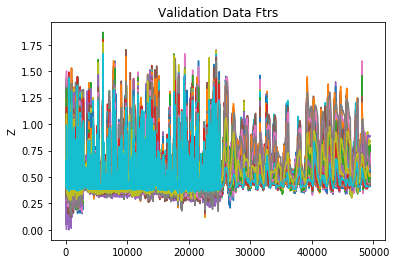

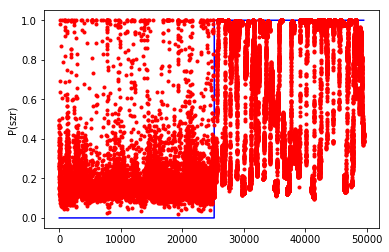

In [33]:
min_ftrs=np.min(ftrs_va)
plt.figure(11)
plt.clf()
plt.plot(np.log10(1-min_ftrs+ftrs_va.T));
plt.title('Validation Data Ftrs')
plt.ylabel('Z')

plt.figure(12)
plt.clf()
plt.plot(targ_labels_va,'b-');
plt.plot(class_hat_va,'r.');
plt.ylabel('P(szr)')

print('True szr: mean(class_hat)=%f' % np.mean(class_hat_va[targ_labels_va==1]))
print('True NON-szr: mean(class_hat)=%f' % np.mean(class_hat_va[targ_labels_va==0]))

Ideal threshold=0.443461
Corresponding sens/spec=0.705210/0.892183
Balanced Accuracy (sens/spec)=0.799 (0.705210/0.892183)


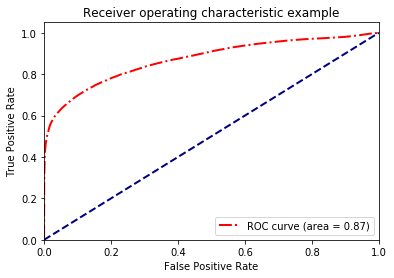

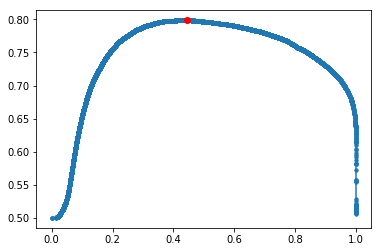

In [13]:
from sklearn.metrics import roc_curve, auc
#fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
fpr, tpr, thresh = roc_curve(targ_labels_va, class_hat_va)
plt.figure(3)
lw = 2
plt.plot(fpr, tpr, 'r-.',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_va)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.figure(4)
mn=(tpr+(1-fpr))/2
mx_mn_id=np.argmax(mn)
plt.plot(thresh,mn,'.-')
plt.plot(thresh[mx_mn_id],mn[mx_mn_id],'ro')
print('Ideal threshold=%f' % thresh[mx_mn_id])
print('Corresponding sens/spec=%f/%f' % (tpr[mx_mn_id],1-fpr[mx_mn_id]))
bal_acc_va, sens_va, spec_va=ief.perf_msrs(targ_labels_va, class_hat_va>=thresh[mx_mn_id])
print('Balanced Accuracy (sens/spec)=%.3f (%f/%f)' % (bal_acc_va,sens_va,spec_va))
# J=sens+spec-1